In [1]:
cd /Users/joepalmo/Desktop/cfa/SDU-preproc

/Users/joepalmo/Desktop/cfa/SDU-preproc


In [2]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import ascii
import os

# open source module found for converting MJD/JD to DateTimes
import jdutil as jd

# Ben's module -- THANKS BEN
import LCtools

# my preprocessing module
from preproc import *

import glob


In [3]:
# # Run to munge LC data
# lc = pd.read_csv(lc_path)
# lc = lc[['hjd', 'mag', 'mag err']]
# lc['mjd'] = jd.jd_to_mjd(lc['hjd'])
# lc = lc.rename(columns={'mag err':'magerr'}).drop(columns='hjd')
# lc.to_csv('mira/Mira_LC.csv')

In [6]:
# specify path to the lightcurve and spectrum
lc_path = "mira/Mira_LC.csv"

# object name (or abbreviation)
n = "Mira"

# resample length for time-sorted LC purposes
resample_len = '5d'

In [7]:
# #load into pandas dataframes
# lc = pd.read_csv(lc_path)
# spec = pd.read_csv(spec_path)

# time_preproc_lc = LC_timesort_preproc(lc, resample_len=resample_len)
# phase_preproc_lc = LC_phasesort_preproc(lc, bins=phase_bins())
# phasefit_preproc_lc = LC_phasefit_preproc(lc_path, bins=phase_bins())
# preproc_spec = spectra_preproc(spec, bins=wavelength_bins())

# #create output directory
# outdir = 'preproc/{}/'.format(n)
# if not os.path.exists(outdir):
#     os.makedirs(outdir)   

# Period in Days

In [8]:
#load data into astropy table, sort by mjd, and remove phase
data = ascii.read(lc_path, format='csv', fast_reader=False)
data.sort('mjd')
#data.remove_column('phase')
flc_data, LC_stat_properties = LCtools.process_LC(data, fltRange=5.0, detrend=True)

#Use LombScargle periodogram to find the best fit period (in days)
omega = LCtools.perdiodSearch(flc_data)[0]['P'] 

print("The period is", omega, "days")

The period is 669.6428571428571 days


# Raw Light Curve Exploration

In [9]:
lc = pd.read_csv(lc_path)
time_preproc_lc = LC_timesort_preproc(lc, resample_len=resample_len)

In [10]:
print("The observations span",str(round(lc.mjd.max()-lc.mjd.min(), 2)),"days")

The observations span 1987.65 days


In [11]:
len(lc)

208

# Time Sorted Light Curve

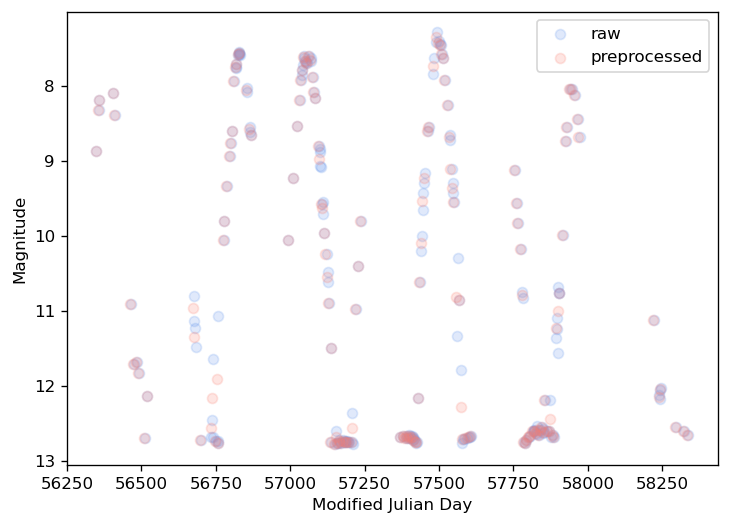

In [12]:
fig1 = plot_timesort(lc, time_preproc_lc)

In [13]:
len(time_preproc_lc)

398

In [14]:
time_preproc_lc_final = time_preproc_lc[time_preproc_lc['Modified Julian Day'].between(56250, 57900)]

In [15]:
len(lc[lc['mjd'].between(56250, 57900)])

189

In [16]:
# percent of the data taken during this one night:
len(lc[lc['mjd'].between(56250, 57900)]) / len(lc) * 100

90.86538461538461

In [17]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(time_preproc_lc_final) / 8.5), "s")

Estimated video time of 36.588235294117645 s


# Phased LC

In [25]:
lc = pd.read_csv(lc_path)
period, phase_preproc_lc, phasefit_preproc_lc = phase_LC(lc, bins=phase_bins(), rephased=False, flc=False, detrend=True, detrend_deg=3, Nmax=1, omega=223)

In [26]:
period

223

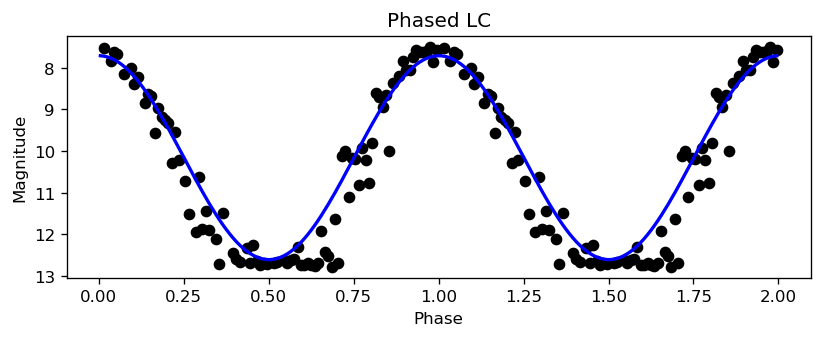

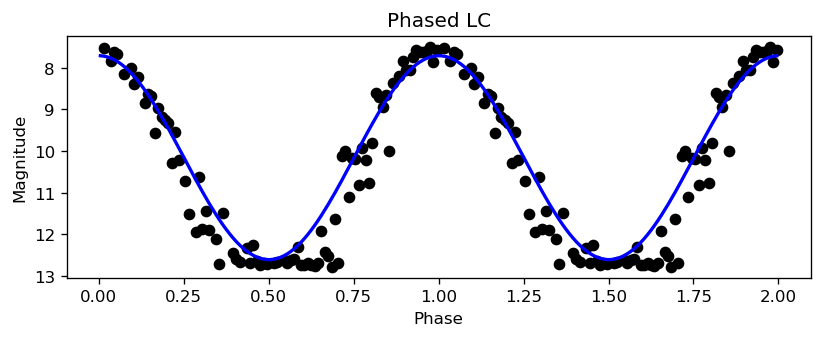

In [27]:
plot_phased(phase_preproc_lc, phasefit_preproc_lc)

# Spectra

In [52]:
spec_path = "mira/Mira_RBoo_spec.dat"

In [53]:
spec = pd.read_csv(spec_path, delimiter='\s+')
spec['flux'] = spec['flux'] / 500000

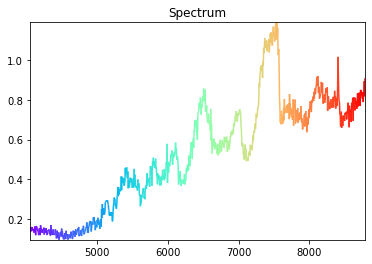

In [54]:
#raw data
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = spec['wavelength'], spec['flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

In [55]:
preproc_spec = spectra_preproc(spec, bins=np.arange(4050,8790,20))

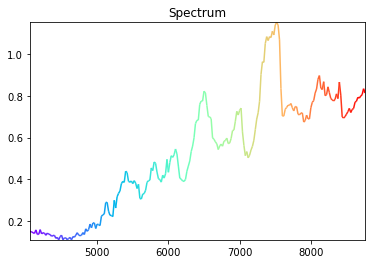

In [56]:
#preprocessed
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = preproc_spec['Wavelength'], preproc_spec['Flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

In [57]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(preproc_spec) / 8.5), "s")

Estimated video time of 27.764705882352942 s


# Save Preprocessed File

In [58]:
#create output directory
outdir = 'preproc/{}/'.format(n)
if not os.path.exists(outdir):
    os.makedirs(outdir)   

In [59]:
#save preprocessed files
time_preproc_lc_final.to_csv("preproc/{}/{}_LC_timesort.csv".format(n,n), index=False)
phase_preproc_lc.to_csv("preproc/{}/{}_LC_phasesort.csv".format(n,n), index=False)
phasefit_preproc_lc.to_csv("preproc/{}/{}_LC_phasefit.csv".format(n,n), index=False)
preproc_spec.to_csv("preproc/{}/{}_spec.csv".format(n,n), index=False)